In [80]:
path = '/home/anurag'
#****************************To be Change to reproduce ou result*********************************************

# location of the data and where to store iamge feature image
path_output_chd = path+'/Med_VQA'    

input_vqa_train = 'train_dataset_pickle/train19_subset20_21_df.pkl'
input_vqa_valid ='valid_dataset_pickle/val19_df.pkl'

img_feat_train = 'train_dataset_pickle/train-image-feature-19-subset20.pickle'
img_feat_valid ='valid_dataset_pickle/valid-image-feature-19-subset20.pickle'

input_test = 'test_dataset_pickle/test19_df.pkl'
img_feat_test = 'test_dataset_pickle/vgg19-test-image-feature.pickle'


In [81]:
import json
import numpy as np
with open(path+'/Med_VQA/answer_classes.json', 'r') as j:
        answer_classes = json.load(j)


l = len(answer_classes) 

print(l)

import easydict
opt = easydict.EasyDict({
        "SEED":97,
        "BATCH_SIZE": 64,
        "VAL_BATCH_SIZE": 64,
        "NUM_OUTPUT_UNITS": l,
        "MAX_QUESTION_LEN": 17,
        "IMAGE_CHANNEL": 1984,
        "INIT_LEARNING_RATE": 1e-4,
        "LAMNDA":0.0001,
        "MFB_FACTOR_NUM":5,
        "MFB_OUT_DIM":1000,
        "BERT_UNIT_NUM":768,
        "BERT_DROPOUT_RATIO":0.3,
        "MFB_DROPOUT_RATIO":0.1,
        "NUM_IMG_GLIMPSE":2,
        "NUM_QUESTION_GLIMPSE":2,
        "IMG_FEAT_SIZE":1,
        "IMG_INPUT_SIZE":224,
        "NUM_EPOCHS":150,
    })

178


In [82]:
train_data_df = np.load(path+'/Med_VQA/'+input_vqa_train, allow_pickle=True)
# test_data_df = np.load(path+'/VQA_Med'+input_test,allow_pickle=True)

In [83]:
train_data_df.shape

(14216, 5)

In [84]:
print(len(train_data_df['labels'].unique().tolist()))

178


In [85]:
train_data_df.head(5)

,ID,Q,A,PATH,labels
0,synpic41148,what kind of image is this?,cta - ct angiography,/home/anurag/Med_VQA/data/raw/ImageCLEF/train_...,32
1,synpic43984,is this a t1 weighted image?,no,/home/anurag/Med_VQA/data/raw/ImageCLEF/train_...,2
2,synpic38930,what type of imaging modality is used to acqui...,us - ultrasound,/home/anurag/Med_VQA/data/raw/ImageCLEF/train_...,15
3,synpic52143,is this a noncontrast mri?,no,/home/anurag/Med_VQA/data/raw/ImageCLEF/train_...,2
4,synpic20934,what type of image modality is this?,xr - plain film,/home/anurag/Med_VQA/data/raw/ImageCLEF/train_...,5


In [86]:

valid_data_df = np.load(path+'/Med_VQA/'+input_vqa_valid,allow_pickle=True)

In [87]:
valid_data_df.shape

(2000, 5)

In [88]:

test_data_df = np.load(path+'/Med_VQA/'+input_test,allow_pickle=True)

In [89]:
test_data_df.shape

(500, 5)

In [90]:
import numpy as np
from torch.utils.data import DataLoader
import easydict
import nltk
import numpy as np
import random
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from transformers import BertTokenizer
from transformers import BertModel
import time
import re
from torchinfo import summary
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate import bleu_score
import os
import matplotlib.pyplot as plt
import nltk
import copy
import pandas as pd
from torch.utils.data import DataLoader

from transformers import VisualBertModel, VisualBertConfig
from transformers import AutoTokenizer, AutoModel


In [91]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print('device',device)

nltk.download('punkt')


device cuda:1


[nltk_data] Downloading package punkt to /home/anurag/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [92]:
seed_value = opt.SEED
np.random.seed(seed_value)
random.seed(seed_value)
torch.manual_seed(seed_value) # return <torch._C.Generator object at 0x7f71cdf7a3d0>
torch.cuda.manual_seed(seed_value) 
torch.cuda.manual_seed_all(seed_value)
torch.backends.cudnn.enabled = False
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [93]:
class VqaDataset(data.Dataset):
    '''
        Main class use to retrieve our dataset from pickle file.
    '''

    def __init__(self, input_dir, input_vqa, img_feat_vqa, transform=None, phase = 'train'):
        # print('vqa_path',input_dir+'/'+input_vqa)
        # print('feat_path',input_dir+'/'+img_feat_vqa)
        self.input_dir = input_dir
        self.vqa = np.load(input_dir+'/'+input_vqa, allow_pickle=True )
        self.img_feat_vqa = np.load(input_dir+'/'+img_feat_vqa, allow_pickle=True )
        self.vocab_size = None
        self.phase = phase
        # print('vqa',self.vqa)
        # print('img_feat_vqa',type(self.img_feat_vqa))
   

    def __getitem__(self, idx):

        vqa = self.vqa
        img_feat_vqa = self.img_feat_vqa
        image_id = vqa['ID'].values[idx]
        image_feat = torch.Tensor(img_feat_vqa[image_id])
        sample = { 'image_feature':image_feat ,  } 
        if (self.phase == 'train' or self.phase == 'valid'):
            qst2dic = vqa['Q'].values[idx]  
            answer = vqa['A'].values[idx]
            label = vqa['labels'].values[idx]
            sample['question'] = qst2dic
            sample['answer'] = answer
            sample['label'] = label
        else:
            sample['image_id'] = image_id
            sample['question'] = vqa['Question'].values[idx]
        return sample

    def __len__(self):

        return len(self.vqa)

In [94]:

# class VqaDataset(data.Dataset):
#     '''
#         Main class use to retrieve our dataset from pickle file.
#     '''

#     def __init__(self, input_dir, input_vqa, img_feat_vqa, transform=None, phase = 'train'):
#         # print('vqa_path',input_dir+'/'+input_vqa)
#         # print('feat_path',input_dir+'/'+img_feat_vqa)
#         self.input_dir = input_dir
#         self.vqa = np.load(input_dir+'/'+input_vqa, allow_pickle=True )
#         self.img_feat_vqa = np.load(input_dir+'/'+img_feat_vqa, allow_pickle=True )
#         self.vocab_size = None
#         self.phase = phase
#         # print('vqa',self.vqa)
#         # print('img_feat_vqa',type(self.img_feat_vqa))
   

#     def __getitem__(self, idx):

#         vqa = self.vqa
#         img_feat_vqa = self.img_feat_vqa
#         image_id = vqa['image_id'].values[idx]
#         image_feat = torch.Tensor(img_feat_vqa[image_id])
#         sample = { 'image_feature':image_feat ,  } 
#         if (self.phase == 'train'):
#             ans2idc_a = vqa['labels_a'].values[idx]
#             ans2dic_b = vqa['labels_b'].values[idx]
#             answer_a = vqa['answer_a'].values[idx]
#             answer_b = vqa['answer_b'].values[idx]
#             question_a = vqa['question_a'].values[idx]
#             question_b = vqa['question_b'].values[idx]
#             sample['label_a'] = ans2idc_a
#             sample['label_b'] = ans2dic_b
#             sample['answer_a'] = answer_a
#             sample['answer_b'] = answer_b
#             sample['question_a'] = question_a
#             sample['question_b'] = question_b
#             sample['lamda'] = vqa['lamda'].values[idx]

#         elif (self.phase == 'valid'):
#             qst2dic = vqa['Question'].values[idx]  
#             answer = vqa['Answer'].values[idx]
#             label = vqa['labels'].values[idx]
#             sample['question'] = qst2dic
#             sample['answer'] = answer
#             sample['label'] = label
        
#         else:
#             sample['image_id'] = image_id
#             sample['question'] = vqa['Question'].values[idx]
            
            
#         return sample

#     def __len__(self):

#         return len(self.vqa)

In [95]:

def get_loader(input_dir, input_vqa_train, input_vqa_valid, img_feat_train, img_feat_valid, batch_size, num_workers,size=228):
    '''
        Load our dataset with dataloader for the train and valid data
    '''

    vqa_dataset = {
        'train': VqaDataset(
            input_dir=input_dir,
            input_vqa=input_vqa_train,
            img_feat_vqa=img_feat_train,
            phase = 'train'),
        'valid': VqaDataset(
            input_dir=input_dir,
            input_vqa=input_vqa_valid,
            img_feat_vqa=img_feat_valid,
            phase = 'valid')}
    

    data_loader = {
        phase: torch.utils.data.DataLoader(
            dataset=vqa_dataset[phase],
            batch_size=batch_size,
            shuffle=True,
            num_workers=num_workers,
            )
        for phase in ['train','valid']}

    return data_loader



In [96]:
class BERTokenizer():

    def __init__(self,opt):
        # Load the BERT tokenizer
        # self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
        self.opt = opt
    #pre-process the text data
    def text_preprocessing(self, text):

        # Remove trailing whitespace
        text = re.sub(r'\s+', ' ', text).strip()

        return text


    # Create a function to tokenize a set of texts
    def preprocessing_for_bert(self, data):
        """Perform required preprocessing steps for pretrained BERT.
        @param    data (np.array): Array of texts to be processed.
        @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
        @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                    tokens should be attended to by the model.
        """
        # Create empty lists to store outputs
        input_ids = []
        attention_masks = []
        MAX_LEN = self.opt.MAX_QUESTION_LEN
        # For every sentence...
        for sent in data:
            
            encoded_sent = self.tokenizer.encode_plus(
                text=self.text_preprocessing(sent),  # Preprocess sentence
                add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
                max_length=MAX_LEN,                  # Max length to truncate/pad
                pad_to_max_length=True,         # Pad sentence to max length
                #return_tensors='pt',           # Return PyTorch tensor
                truncation=True,
                return_attention_mask=True      # Return attention mask
                )
            
            # Add the outputs to the lists
            input_ids.append(encoded_sent.get('input_ids'))
            attention_masks.append(encoded_sent.get('attention_mask'))

        # Convert lists to tensors
        input_ids = torch.tensor(input_ids)
        attention_masks = torch.tensor(attention_masks)

        inputs = { 'input_ids' : input_ids, 'attention_mask': attention_masks }

        return inputs


In [97]:
#Extract the question feature with co-attention
class QuestionFeatureExtractionAtt(nn.Module):
    '''
        Extract the question with co-attention, get from https://github.com/asdf0982/vqa-mfb.pytorch 
    '''

    def __init__(self,opt):

        super(QuestionFeatureExtractionAtt, self).__init__()

        self.opt = opt
        self.NUM_QUESTION_GLIMPSE = self.opt.NUM_QUESTION_GLIMPSE #2
                                          # 5                    #1000
        self.JOINT_EMB_SIZE = self.opt.MFB_FACTOR_NUM * self.opt.MFB_OUT_DIM
        self.Softmax = nn.Softmax(dim=-1)
                                                    #768                       #2
        self.Linear1_q_proj = nn.Linear(self.opt.BERT_UNIT_NUM* self.opt.NUM_QUESTION_GLIMPSE, self.JOINT_EMB_SIZE)
        self.Linear2_q_proj = nn.Linear(self.opt.BERT_UNIT_NUM*self.opt.NUM_QUESTION_GLIMPSE, self.JOINT_EMB_SIZE)
        
        self.Dropout_M = nn.Dropout(p=self.opt.MFB_DROPOUT_RATIO)
        self.dropout = nn.Dropout(self.opt.BERT_DROPOUT_RATIO) 
        self.Conv1_Qatt = nn.Conv2d(self.opt.BERT_UNIT_NUM, self.opt.IMAGE_CHANNEL, 1) 
        self.Conv2_Qatt = nn.Conv2d(self.opt.IMAGE_CHANNEL, self.opt.NUM_QUESTION_GLIMPSE, 1)

    def forward(self,qst_encoding):

        '''
        Question Attention
        '''   
        self.batch_size = qst_encoding.shape[0]
        qst_encoding = self.dropout(qst_encoding)
        qst_encoding_resh =  torch.unsqueeze(qst_encoding, 3)       # N=4 x 768 x T=14 x 1     
        qatt_conv1 = self.Conv1_Qatt(qst_encoding_resh)                   # N x 512 x T x 1
        qatt_relu = F.relu(qatt_conv1)
        qatt_conv2 = self.Conv2_Qatt(qatt_relu)                          # N x 2 x T x 1
        qatt_conv2 = qatt_conv2.contiguous().view(self.batch_size*2,-1)
        qatt_softmax = self.Softmax(qatt_conv2)
        qatt_softmax = qatt_softmax.view(self.batch_size, 2, -1, 1)
        qatt_feature_list = []
        for i in range(self.NUM_QUESTION_GLIMPSE):
            t_qatt_mask = qatt_softmax.narrow(1, i, 1)              # N x 1 x T x 1
            t_qatt_mask = t_qatt_mask * qst_encoding_resh           # N x 768 x T x 1
            t_qatt_mask = torch.sum(t_qatt_mask, 2, keepdim=True)   # N x 768 x 1 x 1
            qatt_feature_list.append(t_qatt_mask)
        qatt_feature_concat = torch.cat(qatt_feature_list, 1)       # N x 1536 x 1 x 1

        return qatt_feature_concat

In [98]:
#Extract the image feature with MFB and co-attention 
class ImageFeatureExtractionAtt(nn.Module):

    '''
        Extract the image with co-attention, get from https://github.com/asdf0982/vqa-mfb.pytorch 
    '''

    def __init__(self,opt):
        super(ImageFeatureExtractionAtt, self).__init__()
        self.opt = opt
        self.MFB_FACTOR_NUM = self.opt.MFB_FACTOR_NUM
        self.MFB_OUT_DIM = self.opt.MFB_OUT_DIM
        self.NUM_IMG_GLIMPSE =self.opt.NUM_IMG_GLIMPSE
        self.IMG_FEAT_SIZE = self.opt.IMG_FEAT_SIZE
        
        self.JOINT_EMB_SIZE = self.opt.MFB_FACTOR_NUM * self.opt.MFB_OUT_DIM
        self.Softmax = nn.Softmax(dim=-1)

        self.Linear1_q_proj = nn.Linear(self.opt.BERT_UNIT_NUM* self.opt.NUM_QUESTION_GLIMPSE, self.JOINT_EMB_SIZE)
        self.Linear_i_proj = nn.Linear(self.opt.IMAGE_CHANNEL*self.opt.NUM_IMG_GLIMPSE, self.JOINT_EMB_SIZE)
        self.Conv_i_proj = nn.Conv2d(self.opt.IMAGE_CHANNEL, self.JOINT_EMB_SIZE, 1)
        

        self.Dropout_M = nn.Dropout(p=self.opt.MFB_DROPOUT_RATIO)

        self.Conv1_Iatt = nn.Conv2d(self.opt.MFB_OUT_DIM, self.opt.IMAGE_CHANNEL, 1) # (1000, 512, 1)
        self.Conv2_Iatt = nn.Conv2d(self.opt.IMAGE_CHANNEL, self.NUM_IMG_GLIMPSE, 1)
    
    def forward(self, img_feature, qstatt_feature):

        '''
        Image Attention with MFB
        '''
        self.batch_size = img_feature.shape[0]
        q_feat_resh = torch.squeeze(qstatt_feature)                              # N x 1536
        i_feat_resh = img_feature.unsqueeze(3)                                   # N x 512 x 196 x 1
        iatt_q_proj = self.Linear1_q_proj(q_feat_resh)                                  # N x 5000
        iatt_q_resh = iatt_q_proj.view(self.batch_size, self.JOINT_EMB_SIZE, 1, 1)      # N x 5000 x 1 x 1
        iatt_i_conv = self.Conv_i_proj(i_feat_resh)                                     # N x 5000 x 196 x 1
        iatt_iq_eltwise = iatt_q_resh * iatt_i_conv
        iatt_iq_droped = self.Dropout_M(iatt_iq_eltwise)                                # N x 5000 x 196 x 1
        iatt_iq_permute1 = iatt_iq_droped.permute(0,2,1,3).contiguous()                 # N x 196 x 5000 x 1
        iatt_iq_resh = iatt_iq_permute1.view(self.batch_size, self.IMG_FEAT_SIZE, self.MFB_OUT_DIM, self.MFB_FACTOR_NUM)
        iatt_iq_sumpool = torch.sum(iatt_iq_resh, 3, keepdim=True)                      # N x 196 x 1000 x 1 
        iatt_iq_permute2 = iatt_iq_sumpool.permute(0,2,1,3)                             # N x 1000 x 196 x 1
        iatt_iq_sqrt = torch.sqrt(F.relu(iatt_iq_permute2)) - torch.sqrt(F.relu(-iatt_iq_permute2))
        iatt_iq_sqrt = iatt_iq_sqrt.reshape(self.batch_size, -1)                           # N x 196000
        iatt_iq_l2 = F.normalize(iatt_iq_sqrt)
        iatt_iq_l2 = iatt_iq_l2.view(self.batch_size, self.MFB_OUT_DIM, self.IMG_FEAT_SIZE, 1)  # N x 1000 x 196 x 1

        iatt_conv1 = self.Conv1_Iatt(iatt_iq_l2)                    # N x 512 x 196 x 1
        iatt_relu = F.relu(iatt_conv1)
        iatt_conv2 = self.Conv2_Iatt(iatt_relu)                     # N x 2 x 196 x 1
        iatt_conv2 = iatt_conv2.view(self.batch_size*self.NUM_IMG_GLIMPSE, -1)
        iatt_softmax = self.Softmax(iatt_conv2)
        iatt_softmax = iatt_softmax.view(self.batch_size, self.NUM_IMG_GLIMPSE, -1, 1)
        iatt_feature_list = []
        for i in range(self.NUM_IMG_GLIMPSE):
            t_iatt_mask = iatt_softmax.narrow(1, i, 1)              # N x 1 x 196 x 1
            t_iatt_mask = t_iatt_mask * i_feat_resh                 # N x 512 x 196 x 1
            t_iatt_mask = torch.sum(t_iatt_mask, 2, keepdim=True)   # N x 512 x 1 x 1
            iatt_feature_list.append(t_iatt_mask)
        iatt_feature_concat = torch.cat(iatt_feature_list, 1)       # N x 1024 x 1 x 1
        iatt_feature_concat = torch.squeeze(iatt_feature_concat)    # N x 1024
        return iatt_feature_concat

In [99]:
class VisualBertClassification(nn.Module):
    def __init__(self,opt,num_classes=178,emb_size=512):
        super(VisualBertClassification,self).__init__()
        VBconfig = VisualBertConfig(visual_embedding_dim=1984)
        self.opt = opt
        self.tokenizer = BERTokenizer(self.opt)
        self.model = VisualBertModel(VBconfig)
        self.linear_text = nn.Linear(768,emb_size)
        self.linear_img = nn.Linear(768, emb_size)
        
        self.classifier = nn.Linear(emb_size*2,num_classes)

    def forward(self,visual_embeds,questions):
        
        # print('visual_embeds',visual_embeds.shape)
        visual_embeds = visual_embeds.transpose(1,2)
        inputs = self.tokenizer.preprocessing_for_bert(questions)
        visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long).to(device)
        # print('visual_token_type_ids',visual_token_type_ids.shape)
        visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.float).to(device)
        # print('visual_attention_mask',visual_attention_mask.shape)
        inputs.update(
            {
                "visual_embeds": visual_embeds,
                "visual_token_type_ids": visual_token_type_ids,
                "visual_attention_mask": visual_attention_mask,
                "output_attentions":True
            }
        ) 
        inputs['input_ids'] = inputs['input_ids'].to(device)
        # inputs['token_type_ids'] = inputs['token_type_ids'].to(device)
        inputs['attention_mask'] = inputs['attention_mask'].to(device)
        inputs['visual_token_type_ids'] = inputs['visual_token_type_ids'].to(device)
        inputs['visual_attention_mask'] = inputs['visual_attention_mask'].to(device)

        outputs = self.model(**inputs)
        # print('outputs',outputs[1].shape)
        # print('pooler_output',outputs['pooler_output'].shape)
        # print('out',outputs[1].shape)
        # print('out2',outputs[0][:, 0])
        text_emb = self.linear_text(outputs[0][:,0])
        # print('text_emb',text_emb.shape)
        img_emb = self.linear_img(outputs[1])
        last_hidden_state = outputs.last_hidden_state
        combined_emb = torch.cat((img_emb,text_emb),dim=1)
        # print('combined',combined_emb)
        logits = self.classifier(combined_emb)
        # print('logits',logits)
        return logits,img_emb,text_emb
        # prediction = self.classifier(outputs['pooler_output'])
        # prediction = F.log_softmax(prediction, -1)
        # return prediction

In [100]:
def load_checkpoint(model, optimizer, filename=None): 
    # Note: Input model & optimizer should be pre-defined. This routine only updates their states. 
    start_epoch = 0 
    if os.path.isfile(filename): 
        print("=> loading checkpoint '{}'".format(filename)) 
        checkpoint = torch.load(filename) 
        start_epoch = checkpoint['epoch'] 
        model.load_state_dict(checkpoint['state_dict']) 
        optimizer.load_state_dict(checkpoint['optimizer']) 
        print("=> loaded checkpoint '{}' (epoch {})" .format(filename,
                                                            checkpoint['epoch'])) 
    else: print("=> no checkpoint found at '{}'".format(filename)) 
    return model, optimizer, start_epoch

def mixup_criterion_vqa(criterion, pred_a, pred_b, a_a, a_b, lam):
    # print(lam * criterion(pred_a, a_a))
    # print((1 - lam) * criterion(pred_b, a_b))
    # print(lam * criterion(pred_a, a_a) + (1 - lam) * criterion(pred_b, a_b))
    return lam * criterion(pred_a, a_a) + (1 - lam) * criterion(pred_b, a_b)


# def accuracy(output, target_a, target_b, lam, topk=(1,)):
#     """Computes the precision@k for the specified values of k"""
   
#     maxk = max(topk)
#     batch_size = target_a.size(0)

#     _, pred = output.topk(maxk, 1, True, True)
#     pred = pred.t()
   

    
#     if target_a.dim() == 2: # multians option
#         _, target = torch.max(target, 1)
    
#     correct_a = pred.eq(target_a.view(1,-1).expand_as(pred))
#     correct_b = pred.eq(target_b.view(1,-1).expand_as(pred))


    

#     # print(pred.eq(target_a))

#     # correct += (lam * pred.eq(target_a.data).cpu().sum().float()
#     #                 + (1 - lam) * pred.eq(target_b.data).cpu().sum().float())


#     res = []
#     for k in topk:
#         correct_k = lam*correct_a[:k].reshape(-1).float().sum(0) + (1-lam) * correct_b[:k].reshape(-1).float().sum(0)

        
#         res.append((correct_k / batch_size))
   
#     return res

# def get_bleu_score(predicted, true_ans_a,true_ans_b,lam):
#     path_output_change = path_output_chd
#     with open(path_output_change+'/answer_classes.json', 'r') as j:
#         answer_classes_dict = json.load(j)
#     score_a = 0.0
#     score_b = 0.0
#     assert (len(predicted) == len(true_ans_a))
#     assert (len(predicted) == len(true_ans_b))
#     ans_keys = list(answer_classes_dict.keys())
#     ans_values = list(answer_classes_dict.values())
    

#     for pred, true_ans in zip(predicted, true_ans_a):
#         index_ans = ans_values.index(pred)
#         score_a += sentence_bleu([true_ans.split(' ')], ans_keys[index_ans].split(' '), smoothing_function=bleu_score.SmoothingFunction().method2)

#     for pred, true_ans in zip(predicted,true_ans_b):
#         index_ans = ans_values.index(pred)

#         score_b += sentence_bleu([true_ans.split(' ')], ans_keys[index_ans].split(' '), smoothing_function=bleu_score.SmoothingFunction().method2)
    

#     score = lam * score_a + (1-lam)* score_b
    
#     return score/len(true_ans_a)


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
   
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
   

    
    if target.dim() == 2: # multians option
        _, target = torch.max(target, 1)
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0)
        res.append((correct_k / batch_size))
   
    return res

def get_bleu_score(predicted, true_ans_text):
    path_output_change = path_output_chd
    with open(path_output_change+'/answer_classes.json', 'r') as j:
        answer_classes_dict = json.load(j)
    score = 0.0
    assert (len(predicted) == len(true_ans_text))
    ans_keys = list(answer_classes_dict.keys())
    ans_values = list(answer_classes_dict.values())
    

    for pred, true_ans in zip(predicted, true_ans_text):
        index_ans = ans_values.index(pred)
        
        score += sentence_bleu([true_ans.split(' ')], ans_keys[index_ans].split(' '), smoothing_function=bleu_score.SmoothingFunction().method2)

    return score/len(true_ans_text)



In [101]:
# def contrastive_loss(img_emb, txt_emb, margin=0.5):
#     pos_score = torch.sum(torch.mul(img_emb, txt_emb), dim=1)
#     neg_score = torch.sum(torch.mul(img_emb, torch.roll(txt_emb, shifts=1, dims=0)), dim=1)
#     loss = torch.mean(torch.max(torch.zeros_like(pos_score), pos_score - neg_score + margin))
#     return loss

# def contrastive_loss(img_emb, txt_emb, labels, margin=0.5):
#     # Compute dot product between image and text embeddings
#     dot_prod = torch.matmul(img_emb, txt_emb.t())
#     print('dot_product',labels.shape)
#     # Construct positive and negative mask based on label similarity
#     pos_mask = labels.unsqueeze(1) == labels.unsqueeze(0)
#     print('pos_mask',pos_mask.shape)
#     neg_mask = ~pos_mask
#     # Compute positive and negative scores
#     pos_score = torch.sum(dot_prod * pos_mask.float(), dim=1)
#     neg_score = torch.max(dot_prod * neg_mask.float(), dim=1)[0]
#     # Compute loss as hinge loss between positive and negative scores
#     loss = torch.mean(torch.max(torch.zeros_like(pos_score), pos_score - neg_score + margin))
#     return loss

def contrastive_loss(img_emb, txt_emb, margin=0.5):
    pos_score = torch.sum(torch.mul(img_emb, txt_emb), dim=1)
    neg_score = torch.sum(torch.mul(img_emb, torch.roll(txt_emb, shifts=1, dims=0)), dim=1)
    loss = torch.mean(torch.max(torch.zeros_like(pos_score), pos_score - neg_score + margin))
    return loss

def combined_loss(output, target, img_emb, txt_emb, margin=0.5, ce_weight=0.5):
    ce_loss = nn.CrossEntropyLoss()(output, target)
    cont_loss = contrastive_loss(img_emb, txt_emb, margin=margin)
    # print('cont_loss',cont_loss)
    loss = ce_weight * ce_loss + (1-ce_weight) * cont_loss
    return loss

In [102]:
since = time.time()

best_acc1 = 0.0
best_acc5 = 0.0

best_epoch = 0

list_train_loss_per_epoch = []
list_valid_loss_per_epoch = []

list_train_acc1_per_epoch = []
list_valid_acc1_per_epoch = []

In [103]:
model = VisualBertClassification( opt=opt ).to(device)
criterian = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(),lr = opt.INIT_LEARNING_RATE,weight_decay=opt.LAMNDA)

input_dir =  path_output_chd 
input_vqa_train = input_vqa_train 
input_vqa_valid = input_vqa_valid

img_feat_train =  img_feat_train
img_feat_valid = img_feat_valid

saved_dir =  path_output_chd

In [104]:

num_epochs = opt.NUM_EPOCHS
image_size = opt.IMG_INPUT_SIZE
num_workers = 0
batch_size = opt.BATCH_SIZE

In [105]:
data_loader = get_loader(
        input_dir = input_dir , 
        input_vqa_train = input_vqa_train, 
        input_vqa_valid = input_vqa_valid,
        img_feat_train = img_feat_train, 
        img_feat_valid = img_feat_valid,
            batch_size = batch_size, 
            num_workers = num_workers,
            size = image_size )

In [106]:
for epoch in range(opt.NUM_EPOCHS):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    for phase in ['train','valid']:
        if phase == 'train':
            model.train()
        else:
            model.eval()
        
        running_loss = 0.0
        top1_acc=0
        top5_acc=0
        bleu=0

        batch_step_size = len(data_loader[phase].dataset) / batch_size
        
        for batch_idx, batch_sample in enumerate(data_loader[phase]):
            # print('batch_sample',batch_sample.keys())
            question = batch_sample['question']
            answer = batch_sample['answer']
            labels = batch_sample['label'].to(device)
            # label_answer_text = batch_sample['answer_text']
            image = batch_sample['image_feature'].to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                logits,img_emb,text_emb = model(image,question)
                _, preds = torch.max(logits, 1)
                # loss = contrastive_loss(img_emb,text_emb,labels)
                loss = combined_loss(logits, labels, img_emb, text_emb)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                
            running_loss += loss.item()

            acc1,acc5 = accuracy(logits.data, labels.data, topk=(1, 5))
            top1_acc += acc1
            top5_acc += acc5
            #bleu score
            b = get_bleu_score(preds, answer)
            bleu += b

            if batch_idx % 10 == 0:
                print('| {} SET | Epoch [{:02d}/{:02d}], Step[{:04d}/{:04d}], Loss: {:.4f}, Top 1 Acc: {:.4f}, Top 5 Acc: {:.4f}, Bleu: {:.4f}'.format(phase.upper(), epoch+1, num_epochs, batch_idx, int(batch_step_size), loss.item(), acc1, acc5, b))#Acc: {:.4f},Bleu: {:.4f},acc, b


        epoch_loss = running_loss/batch_step_size
        epoch_acc1 = top1_acc/batch_step_size
        epoch_acc5 = top5_acc/batch_step_size
        
        epoch_blue = bleu/batch_step_size

        #save the loss and accuracy for train and valid
        if phase =='train':
            list_train_loss_per_epoch.append(epoch_loss)
            list_train_acc1_per_epoch.append(epoch_acc1)
        else:
            list_valid_loss_per_epoch.append(epoch_loss)
            list_valid_acc1_per_epoch.append(epoch_acc1)

        print('{} Loss: {:.4f} Top 1 Acc: {:.4f} Top 5 Acc: {:.4f} Bleu: {:.4f}'.format(
                phase, epoch_loss, epoch_acc1,epoch_acc5, epoch_blue))
            
        # deep copy the model
        if phase == 'valid' and epoch_acc1 > best_acc1: #or epoch_acc5 > best_acc5 ):
            best_acc1 = epoch_acc1
            best_acc5 = epoch_acc5
            best_epoch = epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            

Epoch 0/149
----------


/home/anurag/anaconda3/envs/med_vqa/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


| TRAIN SET | Epoch [01/150], Step[0000/0222], Loss: 3.1893, Top 1 Acc: 0.0000, Top 5 Acc: 0.0312, Bleu: 0.0128
| TRAIN SET | Epoch [01/150], Step[0010/0222], Loss: 2.3287, Top 1 Acc: 0.2188, Top 5 Acc: 0.4844, Bleu: 0.0279
| TRAIN SET | Epoch [01/150], Step[0020/0222], Loss: 2.2713, Top 1 Acc: 0.1094, Top 5 Acc: 0.3750, Bleu: 0.0000
| TRAIN SET | Epoch [01/150], Step[0030/0222], Loss: 2.1629, Top 1 Acc: 0.1094, Top 5 Acc: 0.4219, Bleu: 0.0000
| TRAIN SET | Epoch [01/150], Step[0040/0222], Loss: 2.0948, Top 1 Acc: 0.0312, Top 5 Acc: 0.5156, Bleu: 0.0364
| TRAIN SET | Epoch [01/150], Step[0050/0222], Loss: 2.1522, Top 1 Acc: 0.1406, Top 5 Acc: 0.4219, Bleu: 0.0000
| TRAIN SET | Epoch [01/150], Step[0060/0222], Loss: 2.2145, Top 1 Acc: 0.1406, Top 5 Acc: 0.4219, Bleu: 0.0000
| TRAIN SET | Epoch [01/150], Step[0070/0222], Loss: 2.0561, Top 1 Acc: 0.1094, Top 5 Acc: 0.4531, Bleu: 0.0093
| TRAIN SET | Epoch [01/150], Step[0080/0222], Loss: 1.8049, Top 1 Acc: 0.1719, Top 5 Acc: 0.5156, Bleu:

In [ ]:
def make_plot(history, epoch_max, path_output_chd, type_plot='loss'):
    train = history['train']
    valid = history['valid']
    fig, ax = plt.subplots()
    epochs = range(epoch_max)
    
    
    if type_plot=='loss':
        plt.plot(epochs, train, '-r', lw=2, label='Training loss')
        plt.plot(epochs, valid, '-b',lw=2, label='validation loss')
        plt.legend(borderaxespad=0.)
        plt.title('Training and Validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.savefig(path_output_chd+'/imgs/loss.png')
        
    elif type_plot == 'acc1':
        ltrain = []
        lvalid = []
        for i in range(len(train)):
            ltrain.append(train[i].to('cpu').numpy().tolist())
        for i in range(len(valid)):
            lvalid.append(valid[i].to('cpu').numpy().tolist())
    
        plt.plot(epochs, ltrain, '-r', lw = 2, label='Training Top 1 Accuracy')
        plt.plot(epochs, lvalid, '-b', lw = 2, label='validation Top 1 Accuracy')
        plt.legend(borderaxespad=0.)
        plt.title('Training and Validation Top 1 Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Top 1 Accuracy')
        plt.savefig(path_output_chd+'/imgs/acc1.png')

    elif type_plot == 'acc5':
        ltrain = []
        lvalid = []
        for i in range(len(train)):
            ltrain.append(train[i].to('cpu').numpy().tolist())
        for i in range(len(valid)):
            lvalid.append(valid[i].to('cpu').numpy().tolist())
        plt.plot(epochs, ltrain, '-r', lw = 2, label='Training Top 5 Accuracy')
        plt.plot(epochs, lvalid, '-b', lw = 2, label='validation Top 5 Accuracy')
        plt.legend(borderaxespad=0.)
        plt.title('Training and Validation Top 5 Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Top 5 Accuracy')
        plt.savefig(path_output_chd+'/imgs/acc5.png')
    else:
        ltrain = []
        lvalid = []
        for i in range(len(train)):
            ltrain.append(train[i].to('cpu').numpy().tolist())
        for i in range(len(valid)):
            lvalid.append(valid[i].to('cpu').numpy().tolist())
        plt.plot(epochs, ltrain, '-r', lw = 2, label='Training blue')
        plt.plot(epochs, lvalid, '-b', lw = 2, label='validation blue')
        plt.legend(borderaxespad=0.)
        plt.title('Training and Validation blue')
        plt.xlabel('Epochs')
        plt.ylabel('Blue')
        plt.savefig(path_output_chd+'/imgs/blue.png')

    
    
    plt.show()

Training complete in 153m 24s
Best val Top 1 Acc: 0.721500, Top 5 Acc: 0.946000


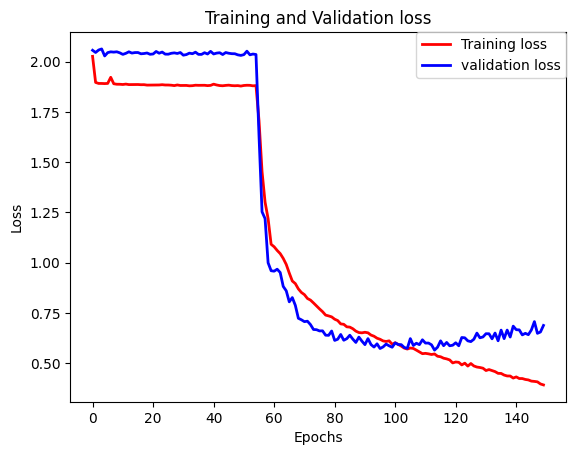

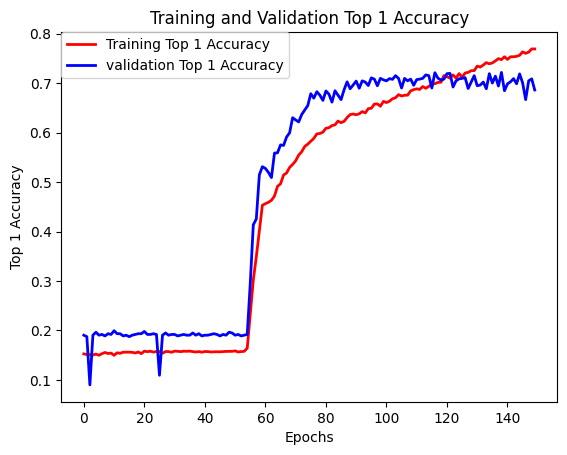

In [ ]:
history_loss = {'train':list_train_loss_per_epoch, 'valid':list_valid_loss_per_epoch}
history_acc1 = {'train':list_train_acc1_per_epoch, 'valid':list_valid_acc1_per_epoch}

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
print('Best val Top 1 Acc: {:4f}, Top 5 Acc: {:4f}'.format(best_acc1,best_acc5))

#plot the loss and accuracy for train and valid
make_plot(history_loss, num_epochs, input_dir, type_plot='loss')
make_plot(history_acc1, num_epochs,input_dir, type_plot='acc1')



# load best model weights
model.load_state_dict(best_model_wts)
model.load_state_dict(best_model_wts)
state = {'epoch': best_epoch, 
        'state_dict': model.state_dict(), 
        'optimizer': optimizer.state_dict(), 
            'loss':epoch_loss,'valid_accuracy': best_acc1}

full_model_path =saved_dir+'/mixed_model_state_seed_97.tar'

torch.save(state, full_model_path)
# return model

In [ ]:
vqa = np.load('/home/arunava/VQA_Med/test_dataset_pickle/test19_df.pkl', allow_pickle=True )

input_test = 'test_dataset_pickle/test_dataset_df.pkl'


In [ ]:
vqa

,ID,Q,A,PATH,labels
0,synpic54733,what imaging modality was used to take this im...,ct with iv contrast,/home/arunava/VQA_Med/data/raw/ImageCLEF/val_2...,33
1,synpic25647,what kind of scan is this?,xr - plain film,/home/arunava/VQA_Med/data/raw/ImageCLEF/val_2...,5
2,synpic35681,was the mri taken with contrast?,no,/home/arunava/VQA_Med/data/raw/ImageCLEF/val_2...,2
3,synpic39641,"is this a t1 weighted, t2 weighted, or flair i...",t2,/home/arunava/VQA_Med/data/raw/ImageCLEF/val_2...,12
4,synpic35693,is this a noncontrast mri?,yes,/home/arunava/VQA_Med/data/raw/ImageCLEF/val_2...,3
...,...,...,...,...,...
1995,synpic45828,what is abnormal in the mri?,marked hydrocephalus due to aqueductal stenosis,/home/arunava/VQA_Med/data/raw/ImageCLEF/val_2...,177
1996,synpic60458,what is abnormal in the x-ray?,discoid meniscus,/home/arunava/VQA_Med/data/raw/ImageCLEF/val_2...,177
1997,synpic43524,what is most alarming about this mri?,"choroid plexus neoplasm, papilloma, carcinoma",/home/arunava/VQA_Med/data/raw/ImageCLEF/val_2...,127
1998,synpic59568,what is abnormal in the mri?,multiple sclerosis,/home/arunava/VQA_Med/data/raw/ImageCLEF/val_2...,62


In [ ]:

def get_test_loader(input_dir,input_test, img_feat_vqa,batch_size, num_workers,size=228):
    test_vqa_dataset = VqaDataset(
            input_dir=input_dir,
            input_vqa=input_test,
            img_feat_vqa=img_feat_vqa,
            phase = 'test')
    data_loader = torch.utils.data.DataLoader(dataset=test_vqa_dataset,
                                                batch_size=batch_size,
                                                shuffle=False,
                                                num_workers=num_workers)
    return data_loader

batch_size = opt.BATCH_SIZE
num_workers = 0
image_size = opt.IMG_INPUT_SIZE

In [ ]:
print('imput_test',input_test)
# Create the DataLoader for our dataset
test_data_loader = get_test_loader(
    input_dir = input_dir , 
    input_test = input_test, 
    img_feat_vqa = img_feat_test,
    batch_size = batch_size, 
    num_workers = num_workers,
    size = image_size )


imput_test test_dataset_pickle/test_dataset_df.pkl


In [ ]:
test_df_res = None
path_change = '/home/arunava'

since = time.time()
model.eval()


VisualBertClassification(
  (model): VisualBertModel(
    (embeddings): VisualBertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (visual_token_type_embeddings): Embedding(2, 768)
      (visual_position_embeddings): Embedding(512, 768)
      (visual_projection): Linear(in_features=1984, out_features=768, bias=True)
    )
    (encoder): VisualBertEncoder(
      (layer): ModuleList(
        (0): VisualBertLayer(
          (attention): VisualBertAttention(
            (self): VisualBertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropou

In [ ]:
results=[]
res={'Image_id':[],'Answer':[]}


In [ ]:
for batch_idx,batch_sample in enumerate(test_data_loader):
    # print('batch_sample',batch_sample)
    image = batch_sample['image_feature'].to(device)
    image_id = batch_sample['image_id']
    questions = batch_sample['question']

    output,img_emb,txt_emb = model(image,questions)
    preds = torch.argmax(output,dim=-1)
    preds = preds.cpu().detach().numpy()

    assert(len(preds) == len(image_id))
    ans_keys = list(answer_classes.keys())
    ans_values = list(answer_classes.values())
    
    for pred, image_name in zip(preds, image_id):
        index_ans = ans_values.index(pred)
        results.append({image_name+'|'+ans_keys[index_ans]})
        res['Image_id'].append(image_name)
        res['Answer'].append(ans_keys[index_ans])


batch_sample {'image_feature': tensor([[[5.0509e-03],
         [0.0000e+00],
         [2.8783e-02],
         ...,
         [4.8391e-03],
         [1.2388e-04],
         [8.9071e-05]],

        [[4.1791e-03],
         [0.0000e+00],
         [1.7559e-02],
         ...,
         [7.8599e-03],
         [2.6479e-03],
         [0.0000e+00]],

        [[8.4814e-03],
         [0.0000e+00],
         [1.6439e-02],
         ...,
         [1.1273e-03],
         [3.7918e-05],
         [4.1715e-04]],

        ...,

        [[2.2584e-03],
         [0.0000e+00],
         [2.8843e-02],
         ...,
         [2.6486e-03],
         [7.8198e-05],
         [2.3279e-04]],

        [[5.0712e-03],
         [0.0000e+00],
         [1.8258e-02],
         ...,
         [4.2934e-03],
         [5.2815e-03],
         [0.0000e+00]],

        [[6.3775e-03],
         [0.0000e+00],
         [1.5576e-02],
         ...,
         [2.2388e-03],
         [8.3069e-03],
         [7.8251e-04]]]), 'image_id': ['synpic54082', 's

/home/arunava/miniconda3/envs/vqamedenv/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


batch_sample {'image_feature': tensor([[[6.3676e-03],
         [0.0000e+00],
         [1.4804e-02],
         ...,
         [1.4119e-03],
         [5.5211e-03],
         [3.6616e-04]],

        [[1.6710e-03],
         [0.0000e+00],
         [2.8773e-02],
         ...,
         [7.2278e-03],
         [3.2115e-03],
         [4.4287e-05]],

        [[4.5462e-03],
         [0.0000e+00],
         [1.3459e-02],
         ...,
         [9.7449e-03],
         [5.7160e-03],
         [4.7371e-04]],

        ...,

        [[6.0191e-03],
         [0.0000e+00],
         [2.0231e-02],
         ...,
         [5.9691e-04],
         [1.3343e-03],
         [5.6330e-05]],

        [[3.7994e-03],
         [0.0000e+00],
         [1.6213e-02],
         ...,
         [2.7946e-03],
         [1.4224e-03],
         [7.5491e-04]],

        [[4.6886e-03],
         [0.0000e+00],
         [1.3601e-02],
         ...,
         [6.6851e-04],
         [0.0000e+00],
         [1.1215e-04]]]), 'image_id': ['synpic40809', 's

In [ ]:
df = pd.DataFrame(results)
test_df_res = pd.DataFrame(res)
df.to_csv(path_change+'/submission_visualbert.csv', index=False) 


In [ ]:
time_elapsed = time.time() - since
print('Evaluation complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))


Evaluation complete in 1m 9s


In [ ]:
test_path = path_change + '/VQA_Med_2019_Dataset/Test/VQAMed2019Test'
test_ref_path = test_path + '/VQAMed2019_Test_Questions_w_Ref_Answers.txt'

with open(test_ref_path) as f:
    lines = f.readlines()

dict_data = {'Image_id':[],
            'Category':[],
            'Question':[],
            'Answer':[]
            }

In [ ]:
for element in lines:
    # print('element',element)
    pd_element = element.split('|')
    # print('pd_element',pd_element[0])
    dict_data['Image_id'].append(pd_element[0])
    dict_data['Category'].append(pd_element[1])
    dict_data['Question'].append(pd_element[2])
    dict_data['Answer'].append(pd_element[3].strip("\n"))

In [ ]:
test_df = pd.DataFrame(dict_data,columns=['Image_id','Category','Question','Answer'])

pred = test_df_res['Answer'].to_list()

truelabels = test_df['Answer'].to_list()

test_df_res['truelabels'] = truelabels

In [ ]:
test_df_res.to_csv(path+'/visualbert_result.csv',index=False)

cnt=0
for i in range(len(pred)):
    if(pred[i] == truelabels[i]): cnt=cnt+1


print((cnt/len(pred))*100)

53.2


In [ ]:
image_ids = res['Image_id']
preds = res['Answer']
questions = dict_data['Question']
answers = dict_data['Answer']
Image_ids = dict_data['Image_id']
categories = dict_data['Category']

In [ ]:
for i in range(len(image_ids)):
    if image_ids[i] != Image_ids[i]:
        print('mismatch at index',i)
        break


In [ ]:
cnt=0
correct ={'modality': 0, 'plane': 0, 'organ': 0, 'abnormality': 0}
count ={'modality': 0, 'plane': 0, 'organ': 0, 'abnormality': 0}


In [ ]:
for i in range(len(image_ids)):
    if (preds[i] == answers[i]): 
        cnt = cnt+1
        correct[categories[i]] = correct[categories[i]]+1
    count[categories[i]] = count[categories[i]]+1  



In [ ]:
print('cnt',cnt)
print('correct',correct)
print('count',count)

cnt 266
correct {'modality': 91, 'plane': 84, 'organ': 80, 'abnormality': 11}
count {'modality': 125, 'plane': 125, 'organ': 125, 'abnormality': 125}
